## Introduction to Data Science 
## Computer Assignment number 3
### Professors: Bahrak and Yaghoob Zade
### Students: Mohamad Mahdi Samadi and Kasra Ghorbani

## Import the required libraries

In [54]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from IPython.display import display, HTML
from pyspark.sql.types import StringType, ArrayType
import matplotlib.pyplot as plt
display(HTML('<style>pre { white-space: pre !important; }</style>'))

## Reading data using pyspark

In [55]:
def read_parquet(path):
    spark = SparkSession.builder.appName("Spotify Data Analysis").getOrCreate()
    df = spark.read.parquet(path)
    return df


FILE_PATH = "./spotify.parquet"
df = read_parquet(path=FILE_PATH)

In [56]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+--------

In [57]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



## Preprocessing

1. **Missing data:** In the third part (analysing by aggregate methods) we found out that there exists an album (optimism 2) with missing data. We searched it on spotify and such an album didn't exist. Assuming they're wrong data it's only logical to remove these songs from our dataframe.

2. **Realease date:** By printing the schema of the dataframe we can see that the column "release_date" with the form YYYY-MM-DD is stored as a string. But it should be of type date.

3. **Artists name and ID:** In pyspark datadrames, columns that contain data in the form of lists are usually stored as strings by default. This is because PySpark's built-in readers treat each row as a flat structure and represent nested structures (like lists or dictionaries) as strings. We'll need to manually parse the string column into a list.

In [58]:
df = df.where(df.album != "Optimism 2")

df = df.withColumn("release_date", F.to_date(
    F.col("release_date"), "yyyy-MM-dd"))

df = df.withColumn("artists", F.from_json(
    F.col("artists"), ArrayType(StringType())))
df = df.withColumn("artist_ids", F.from_json(
    F.col("artist_ids"), ArrayType(StringType())))

## Analyzing

### Analyse by aggregation
Since there are 120 different years, grouping the dataframe by year doesn't provide much useful information. Decades seem more logical.

In [59]:
INTERVAL_SIZE = 10
decade_df = df.withColumn("decade", F.floor(F.col("year") / INTERVAL_SIZE) * INTERVAL_SIZE).groupBy("decade").agg({
    "id": "count",
    "loudness": "mean",
    "energy": "mean",
    "tempo": "mean"
}).sort("decade")

decade_df.show()

+------+-------------------+------------------+---------+-------------------+
|decade|      avg(loudness)|        avg(tempo)|count(id)|        avg(energy)|
+------+-------------------+------------------+---------+-------------------+
|  1900|-14.754137931034485|122.51053448275863|       58| 0.4322568965517241|
|  1910|-16.892826923076928|118.50019230769229|       52|0.25368711538461536|
|  1920|-13.351028199566167|114.99378741865503|      461|0.26763579175704966|
|  1930|-13.777507726269317|117.77362693156724|      453| 0.3246955849889623|
|  1940|-14.964433384379793|113.18361868300147|      653| 0.2427316539050533|
|  1950| -15.60912060778727|110.03512029123122|     3159| 0.2970970940170933|
|  1960|-14.831245901639285|111.94995446265953|     8784|0.35044730383652145|
|  1970|-13.500431356573372| 116.9468723156598|    17183|0.45387753244485946|
|  1980|-14.313751320160883|117.31138901906021|    28595| 0.4661675850043665|
|  1990|-15.110748459643775| 114.6278167253627|   153049| 0.4088

### Analyse by filtering
Filtering in data analysis involves selecting a subset of rows or columns from the dataset.It helps us focus on specific parts of the data.The used filtering methods are filter() and where().

In [60]:
filtered_df_by_year = df.filter(df.year >= 2010).groupBy("year").agg({
    "loudness": "mean",
    "energy": "mean",
    "tempo": "mean"
}).sort("year")
filtered_df_by_year.show()

+----+-------------------+------------------+------------------+
|year|      avg(loudness)|        avg(tempo)|       avg(energy)|
+----+-------------------+------------------+------------------+
|2010|-11.359998989898962|117.91713939393723|0.5235152170033647|
|2011|-11.577590815476938|  117.712370842645| 0.515404043878445|
|2012|-11.296726035292995|118.26418285004954|0.5311194639620416|
|2013|-11.518800460772963|118.17679424237461| 0.518429244130243|
|2014|-11.038182868570056|118.61421182090939|0.5357375865526047|
|2015|-11.016495167318231|119.11751973882096| 0.539310479017565|
|2016|-10.737561705357624|118.94069336032285|0.5470199389967695|
|2017| -10.89803662196923|118.72820581585724|0.5453663143973652|
|2018|-10.177890736553488| 119.5396349457867|0.5695361898018404|
|2019| -9.801963716629857|120.20820849931627|0.5846749907500404|
|2020|  -9.67471618733394|119.39857027899188|0.5851358478505367|
+----+-------------------+------------------+------------------+



ye analyse kossher ro in queen bezan. narahat mishama age hazfesh koni.

In [61]:
filtered_df_by_queen = df.filter(
    F.array_contains(df.artists, "Queen")).sort("album").select(["name", "album", "artists"]).show()

+--------------------+--------------------+--------------------+
|                name|               album|             artists|
+--------------------+--------------------+--------------------+
|Don't Stop Me Now...|Animal Crackers (...|             [Queen]|
|       Brighton Rock|Baby Driver (Musi...|             [Queen]|
|We Will Rock You ...|       Greatest Hits|       [Five, Queen]|
|Greatest Hits Meg...|       Greatest Hits|[Five, Queen, Ste...|
|    We Will Rock You|          Invincible|       [Five, Queen]|
|    We Will Rock You|NOW That's What I...|             [Queen]|
|Tie Your Mother Down|Rock and Roll Hal...|[Queen, Dave Groh...|
|    We Will Rock You|Rock and Roll Hal...|             [Queen]|
|   Bohemian Rhapsody|Wayne's World (Mu...|             [Queen]|
+--------------------+--------------------+--------------------+



### Analyse by transforming
Transforming methods in data analysis involve creating new columns, modifying existing columns, or generating new rows based on existing data.

In [62]:
df = df.withColumn("year", F.year(F.col("release_date")))
df = df.withColumn("month", F.month(F.col("release_date")))
df = df.withColumn("day", F.day(F.col("release_date")))

# Create a new column to show popularity of songs based on danceability, energy and valence
df = df.withColumn("popularity_score", (F.col(
    "danceability") + F.col("energy") + F.col("valence")) / 3)

## Part 4)

An array column is a column containing arrays of values instead of single values. These columns are represented as ArrayType columns. We faced the following challenges. first when we loaded the data, we realized the columns that were supposed to be ArrayType are StrType. An array like [a1,...,an] is stored as a string in between two quotations.As a result we wouldn't be able to access elements of array.We fixed this problem in the preprocessing step. Another potential problem is that when applying aggregation functions directly to them, as these functions typically work with single values, an error rises. Here are two ways to fix the second problem.
1. **select:** we can access and select specific elements from an array column using indexing. in pyspark, we can use the getItem() function from pyspark.sql.functions to access array elements at a given index.

2. **explode:** Which means converting each element of the array into a separate row in the DataFrame. This can prove useful when we want to apply aggregation functions to the individual elements of the array. It obviously increases the data size and makes the code slower.


In [63]:
# adds a new column which contains first artist of the array artists
df.withColumn("first_artist", F.element_at(F.col("artists"), 1))

print("number of songs before separating artists", df.count())
df_exploded = df.withColumn("artist_name", F.explode(F.col("artists")))
print("number of songs after exploding", df_exploded.count())

number of songs before separating artists 1204004


number of songs after exploding 1796330


In [64]:
def show_top_k_songs(measure, k):
    top_k_songs = df.orderBy(F.desc(measure)).limit(k).select(
        "name", "album", "artists", "release_date", measure)
    top_k_songs.show()

In [65]:
show_top_k_songs("liveness", 10)
show_top_k_songs("danceability", 10)
show_top_k_songs("duration_ms", 10)

+--------------------+--------------------+------------------+------------+--------+
|                name|               album|           artists|release_date|liveness|
+--------------------+--------------------+------------------+------------+--------+
|Flood - Live From...|Furthermore: From...|    [Jars Of Clay]|  2003-02-04|     1.0|
| Knock 'Em Dead, Kid|Live at the Whisk...|      [Vince Neil]|  2003-05-27|     1.0|
|       Liar's Corner|  Broadcast 02.09.08|       [Squirtgun]|  2008-07-01|     1.0|
|Si Nos Dejan - En...|Rocio Durcal... E...|    [Rocío Dúrcal]|  2002-10-29|     1.0|
|    Oh, Pretty Woman| Black & White Night|     [Roy Orbison]|  1989-11-23|     1.0|
|That Was A Crazy ...|   Live on Red Rocks|          [O.A.R.]|        NULL|     1.0|
|Santa Monica (Wat...|       Woodstock '99|       [Everclear]|  1999-10-19|     1.0|
|Margaritaville - ...|Live at Wrigley F...|   [Jimmy Buffett]|        NULL|     1.0|
|        Am I The One|    Live At Paradiso|       [Beth Hart]|  2

+--------------------+--------------------+------------------+------------+------------+
|                name|               album|           artists|release_date|danceability|
+--------------------+--------------------+------------------+------------+------------+
|           Unendlich|       Versammlung 1|  [Wolfgang Voigt]|  2015-02-16|         1.0|
| Na-try Mo Na Ba Ako|               Clean|       [Andrew E.]|  2007-02-27|       0.994|
|Roll Like Dis / C...|Mr. C Presents Th...|           [Mr. C]|  2009-03-10|       0.993|
| Techno Is Not Fault| Techno Is Not Fault|[Andrea HEinstein]|  2018-06-08|       0.992|
|Aussie, Aussie (O...|               Clean|       [Andrew E.]|  2007-02-27|       0.991|
|Le casse-tête (Ca...|Coucou Passe-Partout|   [Passe-Partout]|  2019-03-01|       0.991|
|            New Life| Are You Really Lost|   [Matias Aguayo]|  2005-10-04|        0.99|
|       Esther's Vice|          Haralambos|     [Bexar Bexar]|  2003-04-11|        0.99|
|             Go Nuts

+--------------------+--------------------+--------------------+------------+-----------+
|                name|               album|             artists|release_date|duration_ms|
+--------------------+--------------------+--------------------+------------+-----------+
|Bargrooves Deluxe...|Bargrooves Deluxe...|   [Various Artists]|  2018-03-30|    6061090|
|Doctorow's Third Law|Information Doesn...|[Wil Wheaton, Cor...|  2014-12-10|    6054655|
|       Gothic Lolita|The Opheliac Comp...|     [Emilie Autumn]|  2009-11-01|    5764624|
|Bargrooves Deluxe...|Bargrooves Deluxe...|   [Various Artists]|  2016-12-23|    5713196|
|Bargrooves Deluxe...|Bargrooves Deluxe...|   [Various Artists]|  2018-03-30|    5679399|
|Monstercat Podcas...|Monstercat Podcas...|[Monstercat Call ...|  2015-12-15|    5646226|
|Doctorow's Second...|Information Doesn...|[Wil Wheaton, Cor...|  2014-12-10|    5645108|
|Arc Angel - Conti...|           Arc Angel|[Planetary Assaul...|  2016-09-30|    5577278|
|Bargroove

In [66]:
# Assuming df is your DataFrame
michael_jackson_songs = df.filter(
    F.array_contains(df.artists, "Michael Jackson")).sort("year")
mj_average_stats = (
    michael_jackson_songs
    .select(
        F.avg("danceability").alias("mj_avg_danceability"),
        F.avg("energy").alias("mj_avg_energy"),
        F.avg("liveness").alias("mj_avg_liveness"),
        F.avg("tempo").alias("mj_avg_tempo")
    )
)

average_stats = (
    df.select(
        F.avg("danceability").alias("avg_danceability"),
        F.avg("energy").alias("avg_energy"),
        F.avg("liveness").alias("avg_liveness"),
        F.avg("tempo").alias("avg_tempo")
    )
)


mj_average_stats.show()
average_stats.show()

+-------------------+------------------+-------------------+------------------+
|mj_avg_danceability|     mj_avg_energy|    mj_avg_liveness|      mj_avg_tempo|
+-------------------+------------------+-------------------+------------------+
| 0.7363473684210526|0.7089778947368425|0.17401894736842102|113.55842631578949|
+-------------------+------------------+-------------------+------------------+

+-------------------+------------------+-------------------+------------------+
|   avg_danceability|        avg_energy|       avg_liveness|         avg_tempo|
+-------------------+------------------+-------------------+------------------+
|0.49305288657679336|0.5095335065015186|0.20159985543237208|117.63406569164688|
+-------------------+------------------+-------------------+------------------+



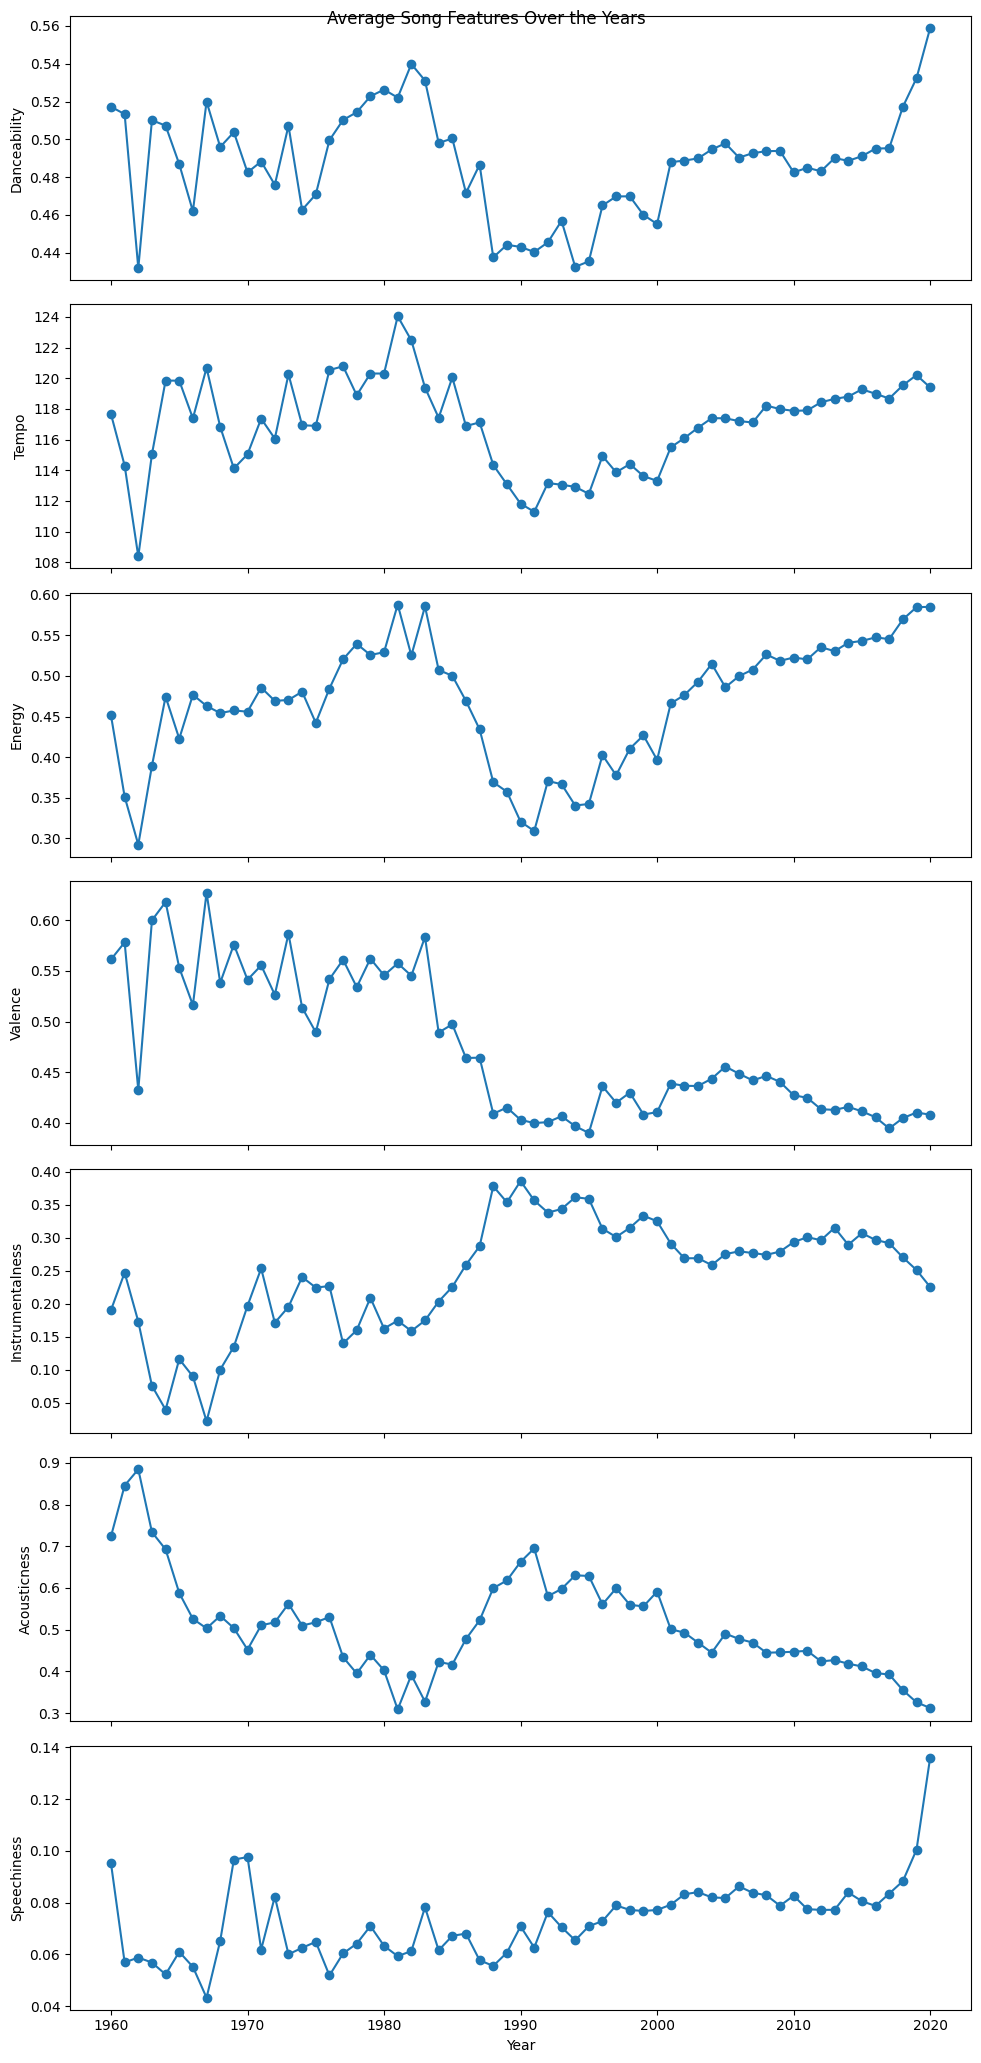

In [68]:
filtered_df = df.filter(df.year >= 1960)
average_yearly_stats = (
    filtered_df.groupBy("year")
    .agg(
        F.avg("danceability").alias("avg_danceability"),
        F.avg("tempo").alias("avg_tempo"),
        F.avg("energy").alias("avg_energy"),
        F.avg("valence").alias("avg_valence"),
        F.avg("instrumentalness").alias("avg_instrumentalness"),
        F.avg("acousticness").alias("avg_acousticness"),
        F.avg("speechiness").alias("avg_speechiness")
    )
    .orderBy("year")
)

average_yearly_stats_pd = average_yearly_stats.toPandas()

features = ["avg_danceability", "avg_tempo", "avg_energy", "avg_valence",
            "avg_instrumentalness", "avg_acousticness", "avg_speechiness"]

fig, axs = plt.subplots(len(features), 1, figsize=(
    10, len(features)*3), sharex=True)

for i, feature in enumerate(features):
    axs[i].plot(average_yearly_stats_pd["year"],
                average_yearly_stats_pd[feature], marker='o', linestyle='-')
    axs[i].set_ylabel(feature.split("_")[-1].capitalize())

axs[-1].set_xlabel('Year')
plt.suptitle('Average Song Features Over the Years (starting from 1960)')

plt.tight_layout()
plt.show()

# Questions
### 1-
Lazy evaluation in systems like Spark and Hadoop means delaying the actual computation of data transformations until it's absolutely necessary. Imagine you have a list of numbers and you want to double each number, then filter out the even ones. Instead of immediately doing these operations one after another, Spark or Hadoop will first create a plan or recipe (like a to-do list) of what needs to be done. It won't actually do anything until you ask for the final result.
### 2-
Columnar Compression: Parquet stores data column-wise rather than row-wise, enabling efficient compression techniques tailored to each column's data type. This results in significant storage savings compared to CSV, as similar values within a column can be compressed more effectively.

Predicate Pushdown: Parquet supports reading only the necessary columns for a query, reducing I/O overhead by fetching and processing only relevant data. This selective reading capability enhances query performance compared to CSV, where entire rows must be retrieved even if only a few columns are needed.

Schema Evolution: Parquet files embed schema information, facilitating seamless evolution of data structures without rewriting the entire dataset. This feature allows for easy addition or modification of columns, ensuring flexibility in managing evolving data requirements.

Parallel Processing: Due to its columnar layout, Parquet enables parallel processing frameworks like Spark or Hadoop to process different columns concurrently, leveraging parallelism for faster data analysis. This parallel processing capability enhances performance when handling large datasets, enabling efficient data processing at scale.
### 3-
While Spark doesn't automatically save checkpoints like some other distributed computing frameworks, you can enforce checkpointing in Spark by explicitly specifying checkpoints in your Spark application code using the checkpoint method. Checkpointing is particularly useful when you have long and complex computation pipelines with multiple steps, as it allows you to recover from failures without redoing the entire computation from scratch.
### 4-
Partitioning: Organize data into logical partitions based on a key column like date. Filtering becomes faster because the system only scans relevant partitions, reducing the data to process.

Indexing: Create indexes on frequently filtered columns like date. Indexes help quickly locate matching rows without scanning the entire dataset, speeding up data retrieval.

Columnar Storage Formats: Store data in formats like Parquet or ORC. These formats store data column-wise, allowing for efficient column-level operations and minimizing I/O overhead during filtering.

Stream Processing Frameworks: Use frameworks like Apache Kafka, Apache Flink, or Apache Spark Streaming. These frameworks offer built-in support for filtering and processing streaming data efficiently, enabling real-time data analysis with optimized performance.
### 5-

Pandas and PySpark are both powerful tools for data analysis, but they shine in different scenarios due to their design principles and architectures. Here's when each library truly shines:

#### Pandas:

Small to Medium-Sized Data: Pandas is ideal for working with small to medium-sized datasets that fit into memory. It offers an intuitive and easy-to-use interface, making it popular among data scientists and analysts for exploratory data analysis and manipulation.
Data Exploration and Cleaning: Pandas provides a rich set of functions for data exploration, cleaning, and transformation. Its DataFrame data structure allows for easy manipulation of tabular data, making it well-suited for tasks like filtering, grouping, and aggregating data.
Interactive Data Analysis: Pandas' interactive nature allows users to quickly iterate on data analysis tasks. Its expressive syntax and rich functionality enable rapid prototyping and experimentation.

#### PySpark:

Big Data Processing: PySpark excels at processing large-scale datasets that cannot fit into memory. It distributes data across a cluster of machines and performs computations in parallel, enabling scalable data processing.
Complex Data Transformations: PySpark is well-suited for handling complex data transformations and analytics tasks on distributed datasets. It leverages the Spark engine's optimization techniques like lazy evaluation, query optimization, and in-memory processing to efficiently execute data processing pipelines.
Integration with Big Data Ecosystem: PySpark seamlessly integrates with other components of the big data ecosystem like Hadoop, HDFS, and Spark SQL. It can process data from various sources and formats, making it versatile for working with diverse data sources.
Factors to Consider:
